In [4]:
# Chatbot with LangGraph

!pip install packaging
!pip install dotenv
!pip install -U langgraph
!pip install -U langchain
!pip install langchain_ollama
!pip install langchain_community

In [5]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [26]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama

# llm = ChatOllama(model="gemma3:4b", base_url="http://localhost:11434")
llm = ChatOllama(model="llama3.2:1b", base_url="http://localhost:11434")

llm.invoke("Hello")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-03T05:53:03.2474836Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4199885300, 'load_duration': 3948624500, 'prompt_eval_count': 26, 'prompt_eval_duration': 172349600, 'eval_count': 8, 'eval_duration': 77302700, 'model_name': 'llama3.2:1b'}, id='run--b570f795-8413-4182-bc49-b8b9c6efe84e-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages":[response]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

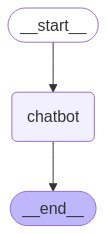

In [28]:
from IPython.display import display, Image

# 랭그래프 구성 이미지화
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
graph.invoke({"messages": ["Hello", "my name is 성종"]})

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='4943243a-c6bf-4397-81b6-e20dac015071'),
  HumanMessage(content='my name is 성종', additional_kwargs={}, response_metadata={}, id='cd559231-1a4d-4c6d-a5c8-fa14b09c9cda'),
  AIMessage(content="Hello 성종. It's not uncommon for people to prefer to go by their given names rather than their full titles or ranks, especially in informal settings. What brings you here today?", additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-03T05:53:11.1622719Z', 'done': True, 'done_reason': 'stop', 'total_duration': 625897600, 'load_duration': 61298900, 'prompt_eval_count': 32, 'prompt_eval_duration': 7244600, 'eval_count': 38, 'eval_duration': 548782200, 'model_name': 'llama3.2:1b'}, id='run--530438dc-2efa-45b1-8175-d2f3640d61ae-0', usage_metadata={'input_tokens': 32, 'output_tokens': 38, 'total_tokens': 70})]}

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

@tool
def internet_search(query: str):
    """
    Search the web for realtime and latest information.
    for examples, news, stock market, weather updates etc.

    Args:
    query: The search query
    """
    search = TavilySearchResults(
        max_results=3,                      # 3개
        search_depth='advanced',
        include_answer=True,
        include_raw_content=True,
        preferred_sites=["news.google.com", "news.naver.com"]
    )

    response = search.invoke(query)
    return response

@tool
def llm_search(query: str):
    """
    Use the LLM model for general and basic information.
    """
    # message = HumanMessage(query)
    response = llm.invoke(query)
    return response


# @tool : LLM이 사용할 수 있는 도구로 제공
internet_search("최신 주식 정보")

[{'title': '국내증시 | 증권 | 뉴스 - 한국경제TV',
  'url': 'https://m.wowtv.co.kr/Finance/DomesticStock/Index?menuSeq=1099',
  'content': '현지시각 2025-05-26 오후 01:55:34 장중 기준\n\n코스피2,627.44\n   35.35\n   1.36%\n\n코스닥725.81\n   9.83\n   1.37%\n\n코스피200349.71\n   4.43\n   1.28%\n\n현지시각 2025-05-26 오후 01:55:34 장중 기준\n\n다우존스41,603.07\n   256.02\n   0.61%\n\n나스닥18,737.21\n   188.53\n   0.99%\n\nS&P5005,802.82\n   39.19\n   0.67%\n\n현지시각 2025-05-26 오후 01:55:34 장중 기준\n\n상해종합3,348.37\n   31.82\n   0.94%\n\n홍콩항생23,366.06\n   235.20\n   0.99%\n\n니케이37,481.63\n   321.16\n   0.86%\n\n관심종목 상세 미국 USD 1,364.00 4.00\n일본 JPY(100엔)956.86 1.29\n유럽연합 EUR 1,556.46 0.43\n중국CNY 190.25 0.41\n\n오늘의 공개방송 [...] 74KODEX 차이나심천8,545 105 1.21%매수\n75미래컴퍼니17,350 170 0.99%매수\n76디아이14,380 220 1.55%보유\n77TIGER 미국나스닥 y20,750 40 0.19%매수\n78오리엔탈정공5,920 320 5.71%매수\n79대한광통신599 9 1.48%보유\n80가온전선77,600 3,800 4.67%매수\n81계양전기1,458 1 0.07%매수\n82아이티센씨티에스613 2 0.33%매수\n83엘티씨9,290 100 1.06%매수\n84한화오션78,700 2,700 3.55%매수\n85에치에프알 019,140 50 0.26%매수

In [31]:
tools = [internet_search, llm_search]
tools

[StructuredTool(name='internet_search', description='Search the web for realtime and latest information.\nfor examples, news, stock market, weather updates etc.\n\nArgs:\nquery: The search query', args_schema=<class 'langchain_core.utils.pydantic.internet_search'>, func=<function internet_search at 0x000002480062E700>),
 StructuredTool(name='llm_search', description='Use the LLM model for general and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llm_search'>, func=<function llm_search at 0x000002480062C540>)]

In [32]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.2:1b', base_url='http://localhost:11434'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'internet_search', 'description': 'Search the web for realtime and latest information.\nfor examples, news, stock market, weather updates etc.\n\nArgs:\nquery: The search query', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'llm_search', 'description': 'Use the LLM model for general and basic information.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [33]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

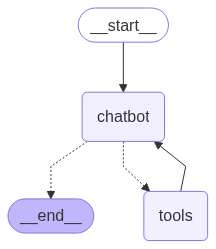

In [34]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# gemma3 가 tools 지원이 없는 모델이라 안됨
graph.invoke({"messages": ["Tell me about the earth in 3 points"]})

{'messages': [HumanMessage(content='Tell me about the earth in 3 points', additional_kwargs={}, response_metadata={}, id='9c8f6544-0d08-4348-bef9-a23a5c4145f7'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-06-03T05:53:16.6433172Z', 'done': True, 'done_reason': 'stop', 'total_duration': 770694000, 'load_duration': 52355200, 'prompt_eval_count': 236, 'prompt_eval_duration': 16388300, 'eval_count': 50, 'eval_duration': 701323200, 'model_name': 'llama3.2:1b'}, id='run--6b6aa24c-9f66-408a-ace6-4753119fa067-0', tool_calls=[{'name': 'internet_search', 'args': {'query': 'earth'}, 'id': 'dcbb24a6-79ab-4c11-89e0-de8cd16c8bd1', 'type': 'tool_call'}, {'name': 'llm_search', 'args': {'query': 'Earth'}, 'id': '6a02c23d-3498-4ff7-b172-54926e249e81', 'type': 'tool_call'}], usage_metadata={'input_tokens': 236, 'output_tokens': 50, 'total_tokens': 286}),
  ToolMessage(content='[{"title": "Earth - Wikipedia", "url": "https://en.wikipedia.org